In [21]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import copy
import pandas as pd
import random
import pickle
import importlib
import datetime
import seaborn as sns


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from sklearn import metrics

import EEGNet as eegnet
importlib.reload(eegnet)

from lrp_methods.lrp import LRPModel

In [22]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [23]:
# import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [24]:
class EarthquakeData(Dataset):
    def __init__(self, h_path, d_path):
        self.c_path = h_path + d_path
        self.h_len = len(h_path)
    
    def __len__(self):
        return len(self.c_path)
    
    def __getitem__(self, idx):
        path = self.c_path[idx]
        start_date = path.split("/")[len(path.split("/"))-1].split(":")[0]

        if idx > self.h_len:
            y = 1
        else:
            y = 0
            
        X = np.loadtxt(path, delimiter=',', dtype=str).astype(np.float32)

        return X, y, start_date

In [25]:
# data_directory = 'area1-all'
second_data_directory = 'area1-all'
# third_data_directory = 'area3-all'

class1_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/" + second_data_directory + "/nonSSE/*.csv")
class2_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/"  + second_data_directory + "/SSE/*.csv")

# class1_paths_second = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/" + third_data_directory + "/nonSSE/*.csv")
# class2_paths_second = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/"  + third_data_directory + "/SSE/*.csv")

# class1_paths = class1_paths + class1_paths_second
# class2_paths = class2_paths + class2_paths_second

# class1_paths_third = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/" + third_data_directory + "/nonSSE/*.csv")
# class2_paths_third = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/"  + third_data_directory + "/SSE/*.csv")

# class1_paths = class1_paths + class1_paths_third
# class2_paths = class2_paths + class2_paths_third

print("Before Undersampling")
print("NonSSE:", len(class1_paths))
print("SSE:", len(class2_paths))

undersample = False
if undersample:
    if class1_paths > class2_paths:
        sampled = random.sample(range(len(class1_paths)), len(class2_paths))
        new_class1_paths = []
        for x in sampled:
            new_class1_paths.append(class1_paths[x])
        class1_paths = new_class1_paths

print(" ")
print("After Undersampling")
print("NonSSE:", len(class1_paths))
print("SSE:", len(class2_paths))

Before Undersampling
NonSSE: 2922
SSE: 2578
 
After Undersampling
NonSSE: 2922
SSE: 2578


In [26]:
datasets = EarthquakeData(class1_paths, class2_paths)

In [27]:
crossvalidationsets = []

key_dates = [[datetime.datetime(1996, 12, 12), datetime.datetime(2000,9,24)], 
             [datetime.datetime(2000,9,25), datetime.datetime(2004,7,7)], 
             [datetime.datetime(2004,7,8), datetime.datetime(2008,4,19)], 
             [datetime.datetime(2008,4,20), datetime.datetime(2012,1,2)]]

# Divide the data into two different sections
for x in range(0, len(key_dates)):
    sse_train = []
    nonsse_train = []
    sse_validation = []
    nonsse_validation = []

    for address in class1_paths:
        first_split = address.split(":")[0].split("/")
        start_date = first_split[len(first_split)-1]
        s_date = start_date.split("-")
        current_start = datetime.datetime(int(s_date[0]), int(s_date[1]), int(s_date[2]))
        if key_dates[x][0] <= current_start <= key_dates[x][1]:
            sse_validation.append(address)
        else:
            sse_train.append(address)

    for address in class2_paths:
        first_split = address.split(":")[0].split("/")
        start_date = first_split[len(first_split)-1]
        s_date = start_date.split("-")
        current_start = datetime.datetime(int(s_date[0]), int(s_date[1]), int(s_date[2]))
        if key_dates[x][0] <= current_start <= key_dates[x][1]:
            nonsse_validation.append(address)
        else:
            nonsse_train.append(address)

    # Create the training dataset
    training_dataset = EarthquakeData(sse_train, nonsse_train)

    # Put validation and test data into dataset and split 50/50
    validationtest_dataset = EarthquakeData(sse_validation, nonsse_validation)
    crossvalidationsets.append([training_dataset, validationtest_dataset])

    print("Iteration: ", x)
    print("Training")
    print("SSE: " + str(len(sse_train)) + " nonSSE: " + str(len(nonsse_train)))
    print("Validation and Testing")
    print("SSE: " + str(len(sse_validation)) + " nonSSE: " + str(len(nonsse_validation)))
    print()

Iteration:  0
Training
SSE: 2109 nonSSE: 2008
Validation and Testing
SSE: 813 nonSSE: 570

Iteration:  1
Training
SSE: 2164 nonSSE: 1954
Validation and Testing
SSE: 758 nonSSE: 624

Iteration:  2
Training
SSE: 2343 nonSSE: 1775
Validation and Testing
SSE: 579 nonSSE: 803

Iteration:  3
Training
SSE: 2150 nonSSE: 1997
Validation and Testing
SSE: 772 nonSSE: 581



In [28]:
path = "/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/cross_validation_results/area1/"
file_names = ['first', 'second', 'third', 'fourth']

fold_stats = []

for count, fold in enumerate(file_names):

    # load the saved model in
    model_path = path + fold + "/saved_model.pth"
    num_chans = 30
    model = eegnet.EEGNet(Chans = num_chans, Samples = 128, nb_classes=1, kernLength=5).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    #set up a dataloader for the dataset
    test_acc = 0
    # test_dataloader = DataLoader(crossvalidationsets[count][1], 1, shuffle=False)
    test_dataloader = DataLoader(datasets, 1, shuffle=False)
    dates = []
    probabilities = []
    predicted_labels = []
    actual_labels = []

    for test_features, test_labels, date in test_dataloader:
        test_features, test_labels = test_features.to(device), test_labels.to(device)
        # test_features = torch.unsqueeze(test_features, 1)
        test_features = test_features.float()
        test_labels = test_labels.float()

        # print(test_labels.shape)
        test_pred = model(test_features)
        test_pred = torch.squeeze(test_pred)
        # test_loss_item = criterion(test_pred, test_labels)
        test_acc_item = eegnet.binary_acc(test_pred, test_labels)

        dates.append(date[0])
        probabilities.append(test_pred.item())
        predicted_labels.append(torch.round(test_pred).item())


        actual_labels.append(test_labels.item())
        # test_loss += test_loss_item.item()
        test_acc += test_acc_item.item()
    fold_stats.append([dates, probabilities, predicted_labels, actual_labels])
    final_test_acc = test_acc/len(test_dataloader)
    print("Fold " + fold + " Testing Accuracy: ", final_test_acc)

Fold first Testing Accuracy:  73.4
Fold second Testing Accuracy:  72.30909090909091
Fold third Testing Accuracy:  62.0
Fold fourth Testing Accuracy:  81.34545454545454


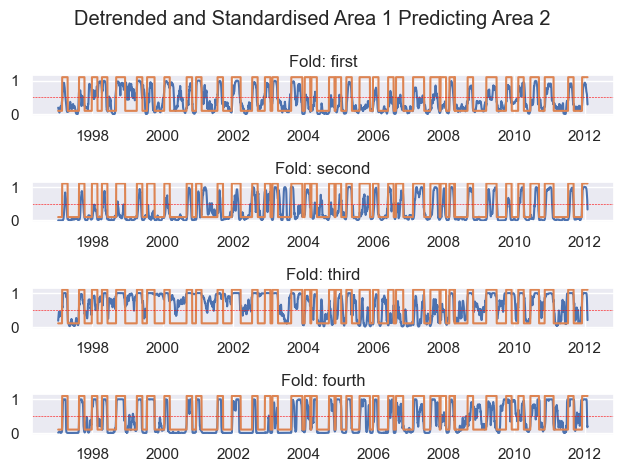

In [29]:
fig, ax = plt.subplots(4, sharey='all')

for index, fold in enumerate(file_names):
    data_frame = pd.DataFrame({'date' : fold_stats[index][0], 'probs' : fold_stats[index][1], 
                               'pred' : fold_stats[index][2], 'actual' : fold_stats[index][3]})
    # data_frame
    data_frame['actual'] = data_frame['actual'] + 0.1
    data_frame = data_frame.sort_values(by='date')
    data_frame['date'] = pd.to_datetime(data_frame['date']) + pd.Timedelta(days=29)
    data_frame.to_csv("./dataframe_csvs/" + fold + "-dt-sd.csv")
    # break

    r_n = range(0, data_frame.shape[0])

    ax[index].plot(data_frame['date'].iloc[r_n], data_frame['probs'].iloc[r_n])
    ax[index].plot(data_frame['date'].iloc[r_n], data_frame['actual'].iloc[r_n])
    ax[index].set_title("Fold: " + fold)
    ax[index].axhline(0.5, color='red', linewidth=0.4, ls="--")

fig.suptitle("Detrended and Standardised Area 1 Predicting Area 2")

fig.tight_layout()
# fig.savefig("dt-sd-area1onarea2.pdf")

Text(0.5, 1.0, 'Predicting on Area 1 Training Data')

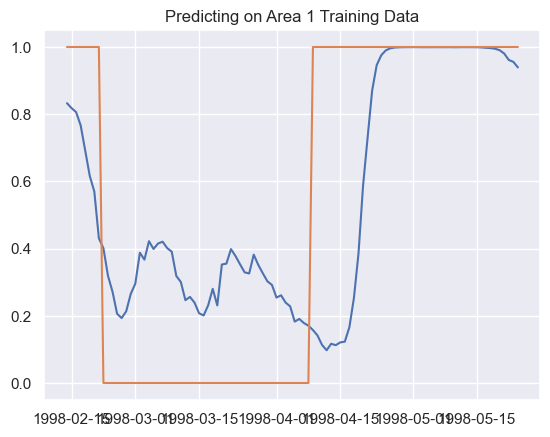

In [30]:
data_frame = pd.DataFrame({'date' : dates, 'probs' : probabilities, 'pred' : predicted_labels, 'actual' : actual_labels})
data_frame['pred'] = data_frame['pred'] + 0.03
data_frame = data_frame.sort_values(by='date')
data_frame['date'] = pd.to_datetime(data_frame['date']) + pd.Timedelta(days=29)

r_n = range(400, 500)

plt.plot(data_frame['date'].iloc[r_n], data_frame['probs'].iloc[r_n])
plt.plot(data_frame['date'].iloc[r_n], data_frame['actual'].iloc[r_n])
# plt.plot(data_frame['date'].iloc[r_n], data_frame['pred'].iloc[r_n])
plt.title("Predicting on Area 1 Training Data")
# plt.legend(['Probability', 'Predicted'])
# plt.savefig("2012-area-1.pdf")

# data_frame.to_csv("./confusion_matrix_data/area3/A2model_A3data.csv")

# Tremor Comparison

In [31]:
dtsd_data_second = pd.read_csv("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/cross_model_loading/dataframe_csvs/second-dt-sd.csv")
dtsd_data_second['date'] = pd.to_datetime(dtsd_data_second['date'])
dtsd_data_second.set_index('date', inplace=True)
ax[0].plot(dtsd_data_second['probs'])
ax[0].plot(dtsd_data_second['actual'])

In [34]:
model_path = "/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/cross_validation_results/area1/first/saved_model.pth"

model = eegnet.EEGNet(Chans = num_chans, Samples = 128, nb_classes=1, kernLength=5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

date_in_q = pd.to_datetime('1998-05-15') - pd.Timedelta(days=29)

first_validation = crossvalidationsets[0][1]

for index in range(len(first_validation)):
    if (pd.to_datetime(first_validation[index][2]) == date_in_q):
        print("Found date")
        found_index = index
        break

picked_point = first_validation[found_index]

print("Start Date:", date_in_q)
print("Actual Label:", picked_point[1])

x = torch.tensor(picked_point[0]).to(device)
x = torch.unsqueeze(x, 0)
p = model(x)
print("Model Confidence:", p.item())

lrp_model = LRPModel(model)
rel = lrp_model.forward(x)
rel = rel.numpy()


Found date
Start Date: 1998-04-16 00:00:00
Actual Label: 1
Model Confidence: 0.9464865326881409


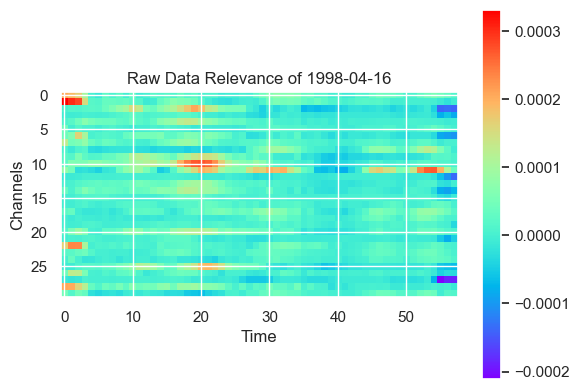

In [39]:
stations = []

sns.set()
for index in range(rel.shape[0]):
    stations.append(sum(rel[index]))

plt.imshow(rel, cmap="rainbow")
plt.colorbar()
plt.title("Raw Data Relevance of 1998-04-16")
plt.ylabel("Channels")
plt.xlabel("Time")

with open('./lrp-numpy-arrays/dtsd_2003-06-21', 'wb') as f:
    np.save(f, rel)

plt.savefig("LRP-positive-example.pdf")


# Detrended And Stanardised LRP

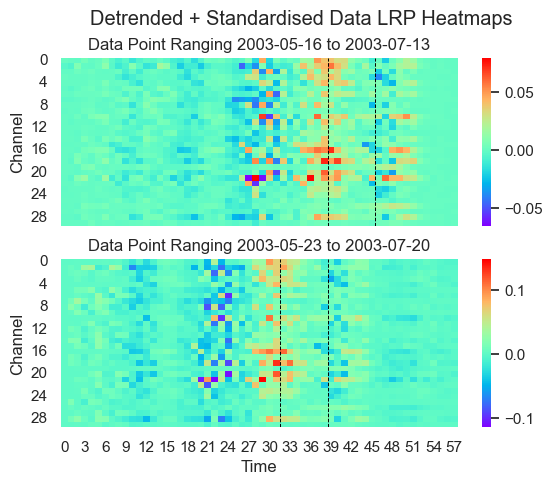

In [ ]:
sns.set()
raw_14 = np.load('./lrp-numpy-arrays/raw_2003-06-14')
raw_21 = np.load('./lrp-numpy-arrays/raw_2003-06-21')

dtsd_14 = np.load('./lrp-numpy-arrays/dtsd_2003-06-14')
dtsd_21 = np.load('./lrp-numpy-arrays/dtsd_2003-06-21')

fig, (ax1,ax2) = plt.subplots(2,1, sharex='all', sharey='all')

g1 = sns.heatmap(dtsd_14, cmap='rainbow', ax=ax1, cbar=True)
g1.set_title("Data Point Ranging 2003-05-16 to 2003-07-13")

g1.set_yticklabels([0, 4, 8, 12, 16, 20, 24, 28], rotation=0)
ax1.axvline(39, linewidth=0.7, color='black', ls="--")
ax1.axvline(46, linewidth=0.7, color='black', ls="--")
# ax1.axhline(12, linewidth=0.7, color='black', ls="--")
# ax1.axhline(20, linewidth=0.7, color='black', ls="--")
# ax1.axhline(23, linewidth=0.7, color='black', ls="--")
# ax1.axhline(26, linewidth=0.7, color='black', ls="--")

g2 = sns.heatmap(dtsd_21, cmap='rainbow', ax=ax2, cbar=True)
g2.set_title("Data Point Ranging 2003-05-23 to 2003-07-20")
g2.set_yticklabels([0, 4, 8, 12, 16, 20, 24, 28], rotation=0)
ax2.axvline(32, linewidth=0.7, color='black', ls="--")
ax2.axvline(39, linewidth=0.7, color='black', ls="--")
ax2.set_xlabel("Time")
ax2.set_ylabel("Channel")
ax1.set_ylabel("Channel")
# fig.supylabel("Channel", label_size=20)
# ax2.axhline(12, linewidth=0.7, color='black', ls="--")
# ax2.axhline(20, linewidth=0.7, color='black', ls="--")
# ax2.axhline(23, linewidth=0.7, color='black', ls="--")
# ax2.axhline(26, linewidth=0.7, color='black', ls="--")

fig.suptitle("Detrended + Standardised Data LRP Heatmaps")

fig.savefig("DTSDLRPexample1.pdf")

# sns.heatmap(dtsd_14, cmap='rainbow', ax=ax3, cbar=False)
# sns.heatmap(dtsd_21, cmap='rainbow', ax=ax4, cbar=False)

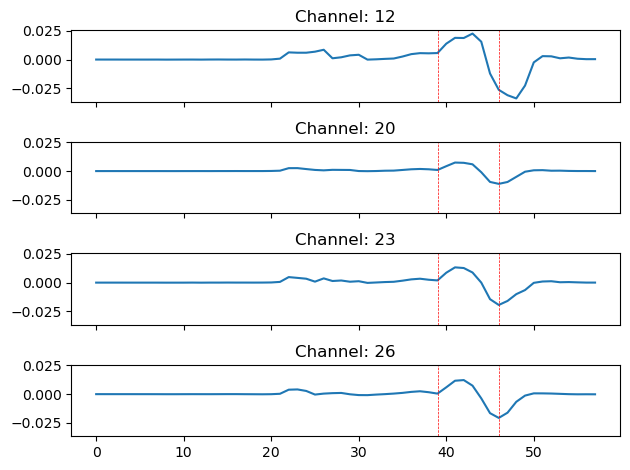

In [ ]:
sns.reset_orig()

fig, ax = plt.subplots(4,1, sharex='all', sharey='all')

ax[0].plot(raw_14[12])
ax[0].axvline(39, color='red', ls='--', linewidth=0.5)
ax[0].axvline(46, color='red', ls='--', linewidth=0.5)
ax[0].set_title("Channel: 12")

ax[1].plot(raw_14[20])
ax[1].axvline(39, color='red', ls='--', linewidth=0.5)
ax[1].axvline(46, color='red', ls='--', linewidth=0.5)
ax[1].set_title("Channel: 20")

ax[2].plot(raw_14[23])
ax[2].axvline(39, color='red', ls='--', linewidth=0.5)
ax[2].axvline(46, color='red', ls='--', linewidth=0.5)
ax[2].set_title("Channel: 23")

ax[3].plot(raw_14[26])
ax[3].axvline(39, color='red', ls='--', linewidth=0.5)
ax[3].axvline(46, color='red', ls='--', linewidth=0.5)
ax[3].set_title("Channel: 26")
fig.tight_layout()

fig.savefig("relevance_area1.pdf")

# plt.plot(raw_14[12])